In [ ]:
from PushshiftDumps.scripts.filter_file import process_file
from datetime import datetime
import ast
import random  # For shuffling the training data
from spacy.training.example import Example
import spacy

from spacy.util import minibatch
import nltk
from nltk.corpus import stopwords
import pandas as pd
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt

# Topic Modeling with BERTopic
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" # Disable parallelism to BERTopic avoid warnings 
import pickle



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Extracting comments from a r/HYPERPOP subreddit dump with terms related to hyperpop
hyperpop_terms = [
    # General Hyperpop Terms
    "hyperpop", "pc music", "100 gecs", "charli xcx", "sophie", "ag cook",  
    "danny l harle", "ravenna golden", "dorian electra", "glitchcore",  
    "bubblegum bass", "nightcore", "electropop", "experimental pop"

    # Artists & Producers
    "sophie xeon", "sophie oil of every pearl", "danny harlecore",  
    "gfoty", "umru", "caro", "fraxiom", "gupi", "laura les", "dylan brady",  
    "osno1", "ericdoa", "aldn", "midwxst", "underscores", "twikipedia",  "dorian electra"
]

input_file = "compressed_subreddits/HYPERPOP_comments.zst"
output_file = "decompressed_subreddits/hyperpop_filter/HYPERPOP_comments"
output_format = "csv"
from_date = datetime.strptime("2018-01-01", "%Y-%m-%d")
to_date = datetime.strptime("2030-12-31", "%Y-%m-%d")
single_field = None
field = "body"
values = hyperpop_terms
exact_match = False  
process_file(input_file, output_file, output_format, field, values, from_date, to_date, single_field, exact_match)

In [106]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def load_data(filename):
    """Loads Reddit data from a CSV file."""
    df = pd.read_csv(filename, header=None, names=["post_id", "date", "username", "url", "text"])
    return df

def clean_text(text):
    """Cleans Reddit post text: removes URLs, special characters, and stopwords."""
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

def apply_cleaning(df):
    """Applies text cleaning to the dataframe."""
    df["clean_text"] = df["text"].apply(clean_text)
    return df

def analyze_sentiment_vader(text, analyzer):
    """Analyzes sentiment using VADER and returns the compound score."""
    scores = analyzer.polarity_scores(text)
    return scores["compound"]

def apply_sentiment_analysis(df):
    """Applies sentiment analysis to the dataframe."""
    analyzer = SentimentIntensityAnalyzer()
    df["sentiment_vader"] = df["clean_text"].apply(lambda x: analyze_sentiment_vader(x, analyzer))
    df["sentiment_label"] = df["sentiment_vader"].apply(lambda x: "positive" if x > 0.05 else "negative" if x < -0.05 else "neutral")
    return df

def save_results(df, output_filename):
    """Saves the processed dataframe to a CSV file."""
    df.to_csv(output_filename, index=False)
    print(f"Results saved to {output_filename}")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yonbui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Perform sentiment analysis on r/HYPERPOP comments
filename = "decompressed_subreddits/hyperpop_filter/HYPERPOP_comments.csv" 
output_filename = "sentiments/hyperpop_filter/HYPERPOP_comments.csv"

df = load_data(filename)
df = apply_cleaning(df)
df = apply_sentiment_analysis(df)

save_results(df, output_filename)

df.head()

In [ ]:
# Visualize the sentiment analysis results on r/HYPERPOP comments that contain hyperpop terms

# Load the processed DataFrame with sentiment analysis results
filename = "sentiments/hyperpop_filter/HYPERPOP_comments.csv"
df = pd.read_csv(filename)

# Set up the visual style for Seaborn
sns.set(style="whitegrid")

# Create a count plot for sentiment labels (positive, neutral, negative)
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="sentiment_label", palette="coolwarm", order=["positive", "neutral", "negative"]), 
plt.title("Sentiment Distribution of Hyperpop-related Posts on r/HYPERPOP")
plt.xlabel("Sentiment Label")
plt.ylabel("Number of Posts")
plt.show()

# Create a distribution plot for sentiment_vader score
plt.figure(figsize=(8, 6))
sns.histplot(df["sentiment_vader"], bins=30, kde=True, color="skyblue")
plt.title("Sentiment Score Distribution (VADER)")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

# Boxplot to show sentiment_vader score distribution by sentiment label
plt.figure(figsize=(8, 6))
sns.boxplot(x="sentiment_label", y="sentiment_vader", data=df, palette="coolwarm")
plt.title("Sentiment Score by Sentiment Label")
plt.xlabel("Sentiment Label")
plt.ylabel("Sentiment Score (VADER)")
plt.show()

# Plot sentiment distribution by year as a line graph.

# Ensure date is datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Drop rows with invalid dates
df = df.dropna(subset=["date"])

# Extract year
df["year"] = df["date"].dt.year

# Count sentiment per year
sentiment_counts = df.groupby(["year", "sentiment_label"]).size().reset_index(name="count")

# Pivot for line plot
sentiment_pivot = sentiment_counts.pivot_table(index="year", columns="sentiment_label", values="count", aggfunc="sum").fillna(0)

# Plot
plt.figure(figsize=(12, 6))
sentiment_pivot.plot(kind="line", marker="o", linestyle='-', figsize=(12, 6))
plt.title("r/HYPERPOP Sentiment Distribution by Year (Hyperpop-related Posts)")
plt.xlabel("Year")
plt.ylabel("Number of Posts")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

In [ ]:
nlp = spacy.load('en_core_web_sm')

# List of terms to label as "HYPERPOP_TERM"
hyperpop_terms = [
    "hyperpop", "pc music", "100 gecs", "charli xcx", "sophie", "ag cook",  
    "danny l harle", "ravenna golden", "dorian electra", "glitchcore",  
    "bubblegum bass", "nightcore", "electropop", "experimental pop",
    "sophie xeon", "sophie oil of every pearl", "danny harlecore",  
    "gfoty", "umru", "caro", "fraxiom", "gupi", "laura les", "dylan brady",  
    "osno1", "ericdoa", "aldn", "midwxst", "underscores", "twikipedia", "dorian electra"
]

# Load the cleaned CSV file
df = pd.read_csv('hyperpop_corpus.csv')

# Function to perform NER and label hyperpop terms explicitly
def label_hyperpop_terms(row):
    text = row['text']
    doc = nlp(text)  # Process the text column
    
    # First, extract existing entities from spaCy's NER
    entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
    
    # Manually add hyperpop terms with custom label and proper character offsets
    for term in hyperpop_terms:
        start = text.lower().find(term.lower())  # Find the start index (case-insensitive)
        while start != -1:  # Loop to handle multiple occurrences of the term
            end = start + len(term)  # Calculate the end index
            entities.append((start, end, "HYPERPOP_TERM"))
            start = text.lower().find(term.lower(), start + 1)  # Find the next occurrence
    
    return {'entities': entities}

# Apply the label function to each row and store the result in a new column
df['entities'] = df.apply(label_hyperpop_terms, axis=1)

# Save the results to a new CSV
df.to_csv('hyperpop_entities_labeled.csv', index=False)

# Print the first few rows of the updated DataFrame to verify
print(df.head())


In [ ]:
# Load the CSV file
df = pd.read_csv('hyperpop_entities_labeled.csv')

# Convert the string representation of entities into actual lists of tuples
def parse_entities(entities_str):
    try:
        # Convert the string representation of the dictionary to a Python object
        entities_dict = ast.literal_eval(entities_str)  # Safe eval to convert string to dict
        
        # Ensure the dictionary contains the "entities" key
        if "entities" not in entities_dict:
            raise ValueError("Missing 'entities' key in dictionary")
        
        # Extract the list of entities
        entities = entities_dict["entities"]
        
        # Validate the format of each entity
        for entity in entities:
            if not (isinstance(entity, tuple) and len(entity) == 3):
                raise ValueError(f"Invalid entity format: {entity}")
        
        return entities
    except Exception as e:
        print(f"Error parsing entities: {e}")
        return []

# Create the training data in the desired format
train_data = []

for _, row in df.iterrows():
    text = row['text']
    entities_str = row['entities']
    
    # Parse the entities
    entities = parse_entities(entities_str)
    
    # Create the training tuple format
    train_data.append((text, {"entities": entities}))

# Output the formatted training data for debugging
for data in train_data:
    print(data)

In [ ]:
def prioritize_hyperpop_term(entities):
    """
    Remove overlapping entities, prioritizing HYPERPOP_TERM.
    """
    # Sort entities by their start and end positions
    entities = sorted(entities, key=lambda x: (x[0], x[1]))
    filtered_entities = []
    
    for start, end, label in entities:
        # Check if the current entity overlaps with any in filtered_entities
        if any(start < e_end and end > e_start for e_start, e_end, e_label in filtered_entities):
            # If the current entity is HYPERPOP_TERM, remove overlapping entities
            if label == "HYPERPOP_TERM":
                filtered_entities = [e for e in filtered_entities if not (start < e[1] and end > e[0])]
                filtered_entities.append((start, end, label))
        else:
            # Add non-overlapping entities
            filtered_entities.append((start, end, label))
    
    return filtered_entities

# Preprocess the training data to prioritize HYPERPOP_TERM
cleaned_train_data = []
for text, annotations in train_data:
    entities = annotations.get("entities", [])
    cleaned_entities = prioritize_hyperpop_term(entities)
    cleaned_train_data.append((text, {"entities": cleaned_entities}))

train_data = cleaned_train_data

In [ ]:
nlp = spacy.load("en_core_web_sm")

# If NER is not in the pipeline, add it
if 'ner' not in nlp.pipe_names:
    ner = nlp.add_pipe("ner", last=True)
else:
    ner = nlp.get_pipe("ner")

# Add custom entity labels
for _, annotations in train_data:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

# Disable other pipes during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.create_optimizer()

    for itn in range(3):  # Adjust number of iterations
        print(f"Starting iteration {itn}")
        random.shuffle(train_data)

        # Subsample for speed
        subset = random.sample(train_data, 3000)  # Adjust as needed

        losses = {}
        batches = minibatch(subset, size=32)
        for batch in batches:
            examples = []
            for text, annotations in batch:
                doc = nlp.make_doc(text)
                example = Example.from_dict(doc, annotations)
                examples.append(example)
            nlp.update(examples, sgd=optimizer, losses=losses)

        print(f"Losses at iteration {itn}: {losses}")
        
        # Save after each iteration
        output_dir = f"hyperpop_ner_model_iter_{itn}"
        os.makedirs(output_dir, exist_ok=True)
        nlp.to_disk(output_dir)
        print(f"Saved model to {output_dir}")

# Final save
nlp.to_disk("hyperpop_ner_model_fast_final")
print("Final model saved to hyperpop_ner_model_fast_final")


In [19]:
# decompress r/HYPERPOP comments
input_file = "compressed_subreddits/HYPERPOP_comments.zst"
output_file = "decompressed_subreddits/HYPERPOP_comments"
output_format = "csv"
from_date = datetime.strptime("2018-01-01", "%Y-%m-%d")
to_date = datetime.strptime("2030-12-31", "%Y-%m-%d")
single_field = None
field = None
values = ['']
exact_match = False  
process_file(input_file, output_file, output_format, field, values, from_date, to_date, single_field, exact_match)

2025-05-01 17:52:43,147 - INFO: Input: compressed_subreddits/HYPERPOP_comments.zst : Output: decompressed_subreddits/HYPERPOP_comments.csv : Is submission False
2025-05-01 17:52:44,001 - INFO: Complete : 47,808 : 47,808 : 0


In [ ]:
# Group by year and collect unique usernames

# Load the CSV file into the dataframe
df = pd.read_csv("decompressed_subreddits/HYPERPOP_comments.csv", header=None, names=["post_id", "date", "username", "url", "text"])

# Ensure the 'date' column is datetime and extract the year
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year

# Group by year and collect unique usernames (as a set)
users_by_year = df.groupby("year")["username"].unique().reset_index()

# Convert the list of usernames to a comma-separated string
users_by_year["username"] = users_by_year["username"].apply(lambda x: ",".join(x))

# Save the results to a new CSV
users_by_year.to_csv("hyperpop_users_by_year.csv", index=False)

print("Results saved to hyperpop_users_by_year.csv")


In [11]:
# Read the CSV file
df = pd.read_csv("decompressed_subreddits/HYPERPOP_comments.csv", header=None, names=["post_id", "date", "username", "url", "text"])

# Drop non-string or missing comments
df = df[df["text"].apply(lambda x: isinstance(x, str))]
df = df[df["text"].notna()]

# Basic filtering
df = df[df["text"].str.split().str.len().between(2, 500)]  # Min 2 words, max 500

# Remove URLs and special characters
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)       # Remove URLs
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)                # Remove symbols
    return text

# Apply the cleaning function to the 'text' column
df["clean_text"] = df["text"].apply(clean_text)

# convert to lists for BERTopic
docs = df["clean_text"].tolist()
timestamps = df["date"].tolist()

In [ ]:
# BERTopic modeling

model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

embeddings = model.encode(docs, show_progress_bar=True)
topic_model = BERTopic(verbose=True, calculate_probabilities=True, \
                       n_gram_range=(1,3), low_memory=True, nr_topics="auto")
topics, probs = topic_model.fit_transform(docs, embeddings)

# Save the topics and probabilities to a Pickle file
with open("hyperpop_topics_and_probs.pkl", "wb") as f:
    pickle.dump(topic_model, f)

Batches: 100%|██████████| 1285/1285 [00:48<00:00, 26.32it/s]
2025-04-14 23:53:35,712 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-14 23:53:46,833 - BERTopic - Dimensionality - Completed ✓
2025-04-14 23:53:46,836 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-15 00:03:15,492 - BERTopic - Cluster - Completed ✓
2025-04-15 00:03:15,496 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-15 00:03:18,596 - BERTopic - Representation - Completed ✓
2025-04-15 00:03:18,601 - BERTopic - Topic reduction - Reducing number of topics
2025-04-15 00:03:18,810 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-15 00:03:21,950 - BERTopic - Representation - Completed ✓
2025-04-15 00:03:21,958 - BERTopic - Topic reduction - Reduced number of topics from 505 to 409


In [55]:
# Get the topic information over time

# Convert timestamps to datetime objects
timestamps_dt = [datetime.strptime(ts, "%Y-%m-%d") for ts in timestamps]

# Grab the year from each timestamp 
timestamps_yearly = [ts.year for ts in timestamps_dt]

topics_over_time = topic_model.topics_over_time(docs, timestamps=timestamps_yearly) 

# Save the topics over time to a Pickle file
with open("hyperpop_topics_over_time.pkl", "wb") as f:
    pickle.dump(topics_over_time, f)

5it [02:36, 31.21s/it]


In [ ]:
with open("hyperpop_topics_and_probs.pkl", "rb") as f:
    topic_model = pickle.load(f)

# Define a list of words to search for in the topic names
search_terms = ["gender", "trans", "woman", "people", "charli xcx", "100 gecs", "soundcloud", "laura les", "sophie", "HYPERPOP", "queer"]

# Combine the search terms into a single regular expression (case-insensitive)
pattern = "|".join(search_terms)

# Get topic information
topic_info = topic_model.get_topic_info()

# Search for topics whose name contains any of the search terms
matches = topic_info[topic_info["Name"].str.contains(pattern, case=False)]


print(matches[["Topic", "Name"]])

     Topic                                               Name
0       -1                             -1_to_and_the_hyperpop
1        0  0_automatically_please contact_removed because...
2        1                 1_vocals_hyperpop_vocal_the vocals
7        6            6_hyperpop_hyperpop is_is hyperpop_call
12      11  11_soundcloud_on soundcloud_your soundcloud_so...
29      28                     28_gecs_100_100 gecs_1000 gecs
49      48                 48_trans_gender_woman_trans people
52      51        51_christians_christian_christianity_people
55      54       54_sophie_sophie sophie_immaterial_by sophie
75      74                       74_queer_gay_lgbtq_community
88      87                     87_xcx_charli xcx_charli_vroom
103    102                102_punk_pop punk_pop_hyperpop punk
122    121                        121_gay_queer_straight_lgbt
167    166                  166_sophie_sophie is_hyperpop_her
169    168     168_money machine_machine_money_100 gecs money
172    1

In [ ]:
topic_model.get_topic(48) 

[('trans', 0.031350545271385),
 ('gender', 0.010988964024477339),
 ('woman', 0.010511182979934844),
 ('trans people', 0.0076081585965161805),
 ('trans woman', 0.007321858971300666),
 ('people', 0.00652673207549086),
 ('being trans', 0.006512691731482347),
 ('female', 0.005812317174423319),
 ('is trans', 0.00563219920869282),
 ('shes', 0.005281355132524578)]

In [115]:
print(topics_over_time.columns)

Index(['Topic', 'Words', 'Frequency', 'Timestamp', 'Name'], dtype='object')


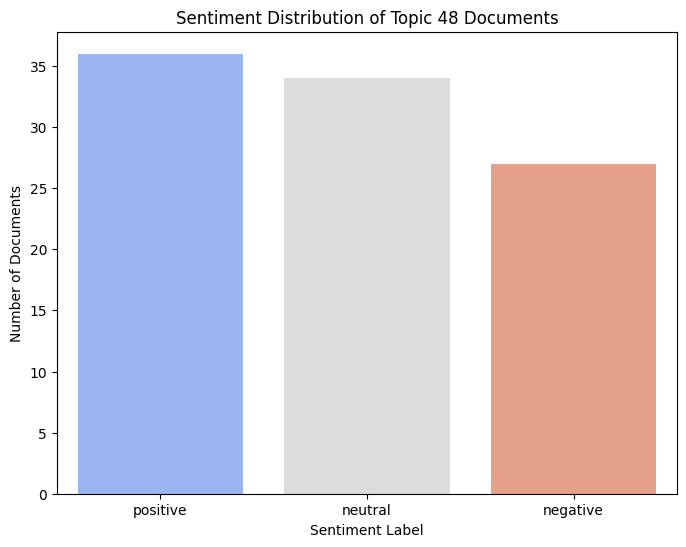

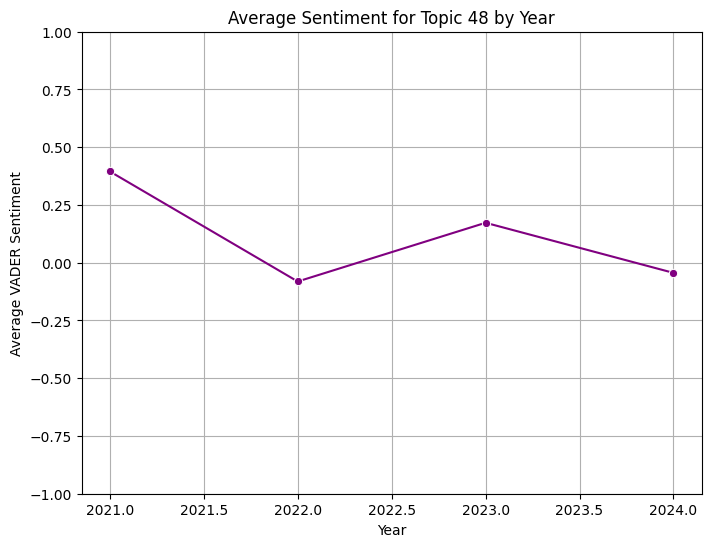

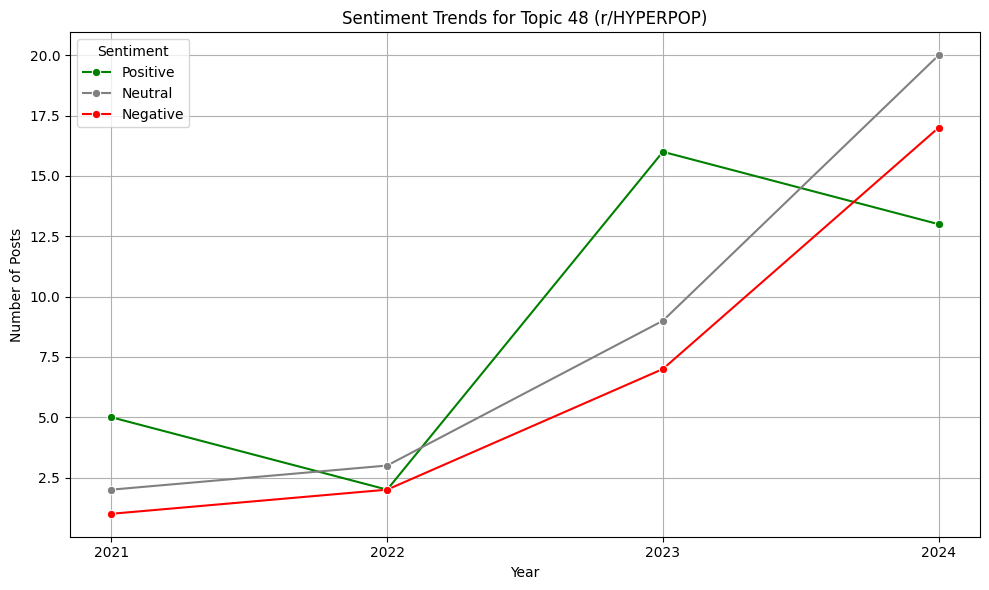

In [ ]:
# Get topics per document
topics = topic_model.get_document_info(docs)["Topic"].tolist()

# Create a DataFrame with documents and their topic
df = pd.DataFrame({
    'documents': docs,
    'topic': topics,
    'date': timestamps
})

# Filter for Topic 48 and reset index
topic_48_df = df[df['topic'] == 48].reset_index(drop=True)

# Add a year column
topic_48_df['date'] = pd.to_datetime(topic_48_df['date'], errors='coerce')
topic_48_df['year'] = topic_48_df['date'].dt.year

# Analyze sentiment
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment_vader(text, analyzer):
    return analyzer.polarity_scores(text)["compound"]

topic_48_df["sentiment_vader"] = topic_48_df["documents"].apply(lambda x: analyze_sentiment_vader(x, analyzer))
topic_48_df["sentiment_label"] = topic_48_df["sentiment_vader"].apply(
    lambda x: "positive" if x > 0.05 else "negative" if x < -0.05 else "neutral"
)

avg_sentiment_by_year = topic_48_df.groupby('year')['sentiment_vader'].mean().reset_index()

sentiment_label_by_year = (
    topic_48_df.groupby(['year', 'sentiment_label'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)



# Plot sentiment label distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=topic_48_df, x="sentiment_label", palette="coolwarm", order=["positive", "neutral", "negative"])
plt.title("Sentiment Distribution of Topic 48 Documents")
plt.xlabel("Sentiment Label")
plt.ylabel("Number of Documents")
plt.show()

# Plot sentiment score by year
plt.figure(figsize=(8, 6))
sns.lineplot(data=avg_sentiment_by_year, x='year', y='sentiment_vader', marker='o', color='purple')
plt.title("Average Sentiment for Topic 48 by Year")
plt.xlabel("Year")
plt.ylabel("Average VADER Sentiment")
plt.ylim(-1, 1)  # VADER sentiment range
plt.grid(True)
plt.show()

# Plot sentiment distribution by year
plt.figure(figsize=(10, 6))
sns.lineplot(data=sentiment_label_by_year, x='year', y='positive', marker='o', label='Positive', color='green')
sns.lineplot(data=sentiment_label_by_year, x='year', y='neutral', marker='o', label='Neutral', color='gray')
sns.lineplot(data=sentiment_label_by_year, x='year', y='negative', marker='o', label='Negative', color='red')
plt.title("Sentiment Trends for Topic 48 (r/HYPERPOP)")
plt.xlabel("Year")
plt.ylabel("Number of Posts")
plt.legend(title="Sentiment")
plt.grid(True)
plt.xticks(sentiment_label_by_year['year'])  # Ensure clean year ticks
plt.tight_layout()
plt.show()

fig = topic_model.visualize_barchart(top_n_topics=5, topics=[48], width=500, height=500)
fig.update_layout(
    title_x=0.5,
    font=dict(size=14),
    margin=dict(l=40, r=40, t=60, b=40),
    xaxis_title='Probability',
    yaxis_title='Words'
)
fig.show()


In [73]:
with open("hyperpop_topics_and_probs.pkl", "rb") as f:
    topic_model = pickle.load(f)

# Get the topic information
topic_model.get_topic_info(48)

# Visualize the topics
topic_model.visualize_topics()

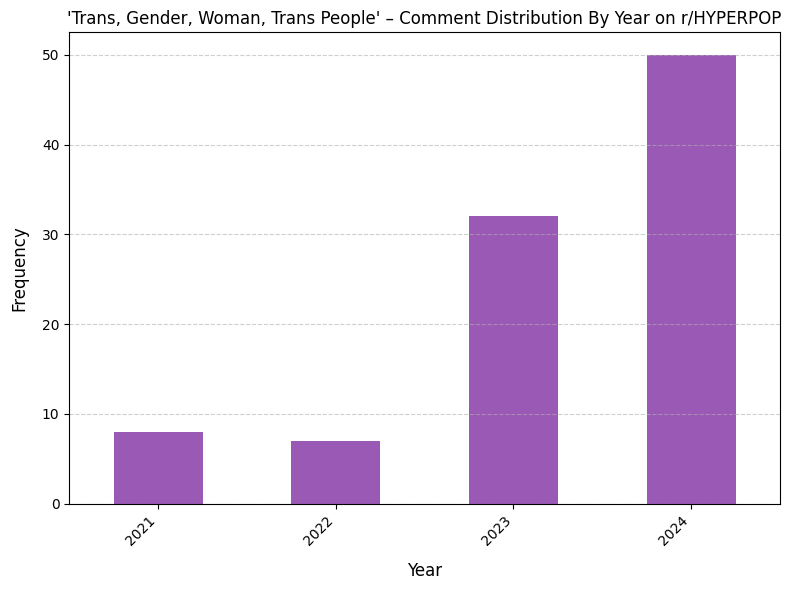

In [ ]:
topics_over_time = pd.read_pickle("hyperpop_topics_over_time.pkl")
topic_48_over_time = topics_over_time[topics_over_time["Topic"] == 48]
ax = topic_48_over_time.groupby("Timestamp")["Frequency"].sum().plot(
    kind="bar", 
    figsize=(8, 6), 
    color=["#9B59B6"],  
    title="'Trans, Gender, Woman, Trans People' – Comment Distribution By Year on r/HYPERPOP",
    legend=False
)

# Add axis labels
ax.set_xlabel("Year", fontsize=12, labelpad=10)  # Label for X-axis (Time)
ax.set_ylabel("Frequency", fontsize=12, labelpad=10)  # Label for Y-axis (Frequency)

# Add grid for better readability
ax.grid(True, axis="y", linestyle="--", alpha=0.6)

# Rotate the x-axis labels for readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Display the plot
plt.tight_layout() 
plt.show()

In [3]:
with open("hyperpop_topics_over_time.pkl", "rb") as f:
    topics_over_time = pickle.load(f)
with open("hyperpop_topics_and_probs.pkl", "rb") as f:
    topic_model = pickle.load(f)
topic_model.visualize_topics_over_time(topics_over_time, topics=[11, 48, 87], title="r/HYPERPOP Topics Over Time", width=800, height=400)
# topic_model.visualize_topics_over_time(topics_over_time, topics=[11, 28, 87, 48, 54, 171, 121], title="r/HYPERPOP Topics Over Time", width=800, height=400)


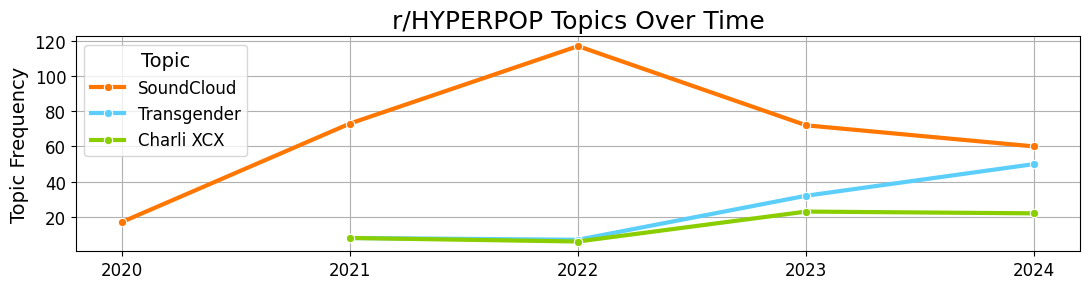

In [54]:
filtered_topics = topics_over_time[topics_over_time['Topic'].isin([11, 48, 87])]

topic_labels = {11: 'SoundCloud', 48: 'Transgender', 87: 'Charli XCX'}
filtered_topics['Topic'] = filtered_topics['Topic'].map(topic_labels)

custom_palette = {
    'SoundCloud': '#ff7700',   # classic SoundCloud orange
    'Transgender': '#5BCEFA',  # trans blue
    'Charli XCX': '#8ACE00'    # brat green
}

plt.figure(figsize=(11, 3))
sns.lineplot(
    data=filtered_topics,
    x='Timestamp',
    y='Frequency',
    hue='Topic',
    palette=custom_palette,
    marker='o',
    linewidth=3
)

plt.title("r/HYPERPOP Topics Over Time", fontsize=18)
plt.xlabel("", fontsize=0)
plt.ylabel("Topic Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(filtered_topics['Timestamp'].unique(), fontsize=12)
plt.legend(title="Topic", fontsize=12, title_fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
with open("hyperpop_topics_over_time.pkl", "rb") as f:
    topics_over_time = pickle.load(f)
with open("hyperpop_topics_and_probs.pkl", "rb") as f:
    topic_model = pickle.load(f)
topic_model.visualize_topics_over_time(topics_over_time, topics=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], title="Top r/HYPERPOP Topics Over Time", width=800, height=400)


In [159]:
topic_model.get_topic(1)

[('vocals', 0.005317572684567071),
 ('hyperpop', 0.004107373684675372),
 ('vocal', 0.0030902344117196565),
 ('the vocals', 0.003036988779839345),
 ('the', 0.003030670012076721),
 ('pitch', 0.00265181901894246),
 ('to', 0.002560541874812815),
 ('and', 0.0024394543494872588),
 ('it', 0.002373574631020163),
 ('pop', 0.0023679561157256787)]

In [164]:
topic_info = topic_model.get_document_info(docs)
topic_1_docs = topic_info[topic_info['Topic'] == 1]

# Show top 5 documents with highest probability of being in topic 1
topic_1_docs.sort_values("Probability", ascending=False).head(5)['Document']

10941    Hyperpop in its current form was heavily infor...
30472    these thoughts make sense im not sure there ar...
10638    Yeah but I didnt think artists like yeat autum...
26845    Pitch shift is overrated Wayyyy too many artis...
10609    Hey I saw your hyperpop glitchcore playlist an...
Name: Document, dtype: object

In [10]:
print(topics_over_time.columns)


Index(['Topic', 'Words', 'Frequency', 'Timestamp'], dtype='object')


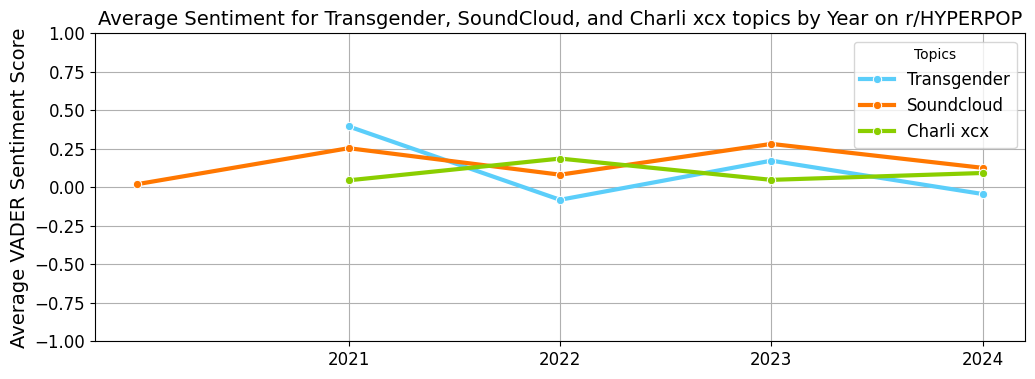

In [56]:
# Get topics per document
topics = topic_model.get_document_info(docs)["Topic"].tolist()

# Create a DataFrame with documents and their topic
df = pd.DataFrame({
    'documents': docs,
    'topic': topics,
    'date': timestamps
})

# Filter for Topic 48 and reset index
topic_48_df = df[df['topic'] == 48].reset_index(drop=True)
topic_11_df = df[df['topic'] == 11].reset_index(drop=True)
topic_87_df = df[df['topic'] == 87].reset_index(drop=True)

# Add a year column
for topic_df in [topic_48_df, topic_11_df, topic_87_df]:
    topic_df['date'] = pd.to_datetime(topic_df['date'], errors='coerce')
    topic_df['year'] = topic_df['date'].dt.year

# Analyze sentiment
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment_vader(text, analyzer):
    return analyzer.polarity_scores(text)["compound"]

for topic_df in [topic_48_df, topic_11_df, topic_87_df]:
    topic_df["sentiment_vader"] = topic_df["documents"].apply(lambda x: analyze_sentiment_vader(x, analyzer))
    topic_df["sentiment_label"] = topic_df["sentiment_vader"].apply(
        lambda x: "positive" if x > 0.05 else "negative" if x < -0.05 else "neutral"
    )

avg_sentiment_by_year48 = topic_48_df.groupby('year')['sentiment_vader'].mean().reset_index()
avg_sentiment_by_year11 = topic_11_df.groupby('year')['sentiment_vader'].mean().reset_index()
avg_sentiment_by_year87 = topic_87_df.groupby('year')['sentiment_vader'].mean().reset_index()

sentiment_label_by_year48 = (
    topic_48_df.groupby(['year', 'sentiment_label'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)
sentiment_label_by_year11 = (
    topic_11_df.groupby(['year', 'sentiment_label'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)
sentiment_label_by_year87 = (
    topic_87_df.groupby(['year', 'sentiment_label'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)
# Plot sentiment scores by year for each topic
plt.figure(figsize=(12, 4))
sns.lineplot(data=avg_sentiment_by_year48, x='year', y='sentiment_vader', marker='o', label='Transgender', color='#5BCEFA', linewidth=3)
sns.lineplot(data=avg_sentiment_by_year11, x='year', y='sentiment_vader', marker='o', label='Soundcloud', color='#ff7700', linewidth=3)
sns.lineplot(data=avg_sentiment_by_year87, x='year', y='sentiment_vader', marker='o', label='Charli xcx', color='#8ACE00', linewidth=3)
plt.title("Average Sentiment for Transgender, SoundCloud, and Charli xcx topics by Year on r/HYPERPOP", fontsize=14)
plt.xlabel("")
plt.ylabel("Average VADER Sentiment Score", fontsize=14)
plt.ylim(-1, 1)  # VADER sentiment range
plt.grid(True)
plt.legend(title="Topics", fontsize=12)
plt.xticks(avg_sentiment_by_year48['year'].unique(), fontsize=12)
plt.yticks(fontsize=12)
plt.show()